# Customer Lifetime Value (LTV) Prediction for Revolut

## 1. Problem Definition and Business Context
Revolut, a leading fintech company, aims to maximize customer retention and profitability by predicting Customer Lifetime Value (LTV). Accurate LTV prediction enables personalized financial recommendations, targeted marketing, and better resource allocation.

**Objective:** Build and compare machine learning models to predict LTV using a digital wallet dataset.

## 2. Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

kaggle_path = '/kaggle/input/fintech-customer-life-time-value-ltv-dataset/digital_wallet_ltv_dataset.csv'
colab_runtime_path = '/content/digital_wallet_ltv_dataset.csv'  # Colab local runtime FS
local_path = './digital_wallet_ltv_dataset.csv'

if os.path.exists(kaggle_path):
    df = pd.read_csv(kaggle_path)
elif os.path.exists(colab_runtime_path):
    df = pd.read_csv(colab_runtime_path)
elif os.path.exists(local_path):
    df = pd.read_csv(local_path)
else:
    raise FileNotFoundError("CSV file not found in Kaggle input, Colab runtime, or local path.")

# Display the first few rows
df.head()


,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV
0,cust_0000,54,Urban,Low,192,16736.384023,60216.834510,6525.814861,3.213386e+06,140,209,2114,25,2224.012140,Monthly,Debit Card,3,61.568590,1,3.279546e+05
1,cust_0001,67,Suburban,High,979,14536.734683,48350.100272,2186.742245,1.423146e+07,229,240,2960,20,4026.823518,Monthly,UPI,17,60.392889,8,1.437053e+06
2,cust_0002,44,Urban,High,329,7061.372800,32521.157187,2743.406808,2.323192e+06,73,21,3170,0,1441.011395,Monthly,Debit Card,11,45.305579,4,2.419387e+05
3,cust_0003,30,Rural,High,71,16426.876453,17827.896720,4360.784994,1.166308e+06,299,285,4756,35,4365.855580,Weekly,Wallet Balance,6,22.030191,1,1.284599e+05
4,cust_0004,58,Urban,Middle,878,10800.092660,17497.634534,4532.872520,9.482481e+06,236,329,1992,18,4161.523827,Daily,UPI,18,20.634723,5,9.569514e+05


In [132]:
# Basic info
print('Shape:', df.shape)
print(df.info())
print(df.describe())

Shape: (7000, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  7000 non-null   object 
 1   Age                          7000 non-null   int64  
 2   Location                     7000 non-null   object 
 3   Income_Level                 7000 non-null   object 
 4   Total_Transactions           7000 non-null   int64  
 5   Avg_Transaction_Value        7000 non-null   float64
 6   Max_Transaction_Value        7000 non-null   float64
 7   Min_Transaction_Value        7000 non-null   float64
 8   Total_Spent                  7000 non-null   float64
 9   Active_Days                  7000 non-null   int64  
 10  Last_Transaction_Days_Ago    7000 non-null   int64  
 11  Loyalty_Points_Earned        7000 non-null   int64  
 12  Referral_Count               7000 non-null   int64  
 13  

### Check for missing values and duplicates

In [133]:
print(df.isnull().sum())
print('Duplicate Customer_IDs:', df['Customer_ID'].duplicated().sum())

Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
dtype: int64
Duplicate Customer_IDs: 0


## 3. Exploratory Data Analysis (EDA)

In [134]:
# Categorical feature distributions
for col in ['Location', 'Income_Level', 'App_Usage_Frequency', 'Preferred_Payment_Method']:
    print(f"\n{col} Distribution:")
    print(df[col].value_counts())


Location Distribution:
Location
Urban       2368
Suburban    2320
Rural       2312
Name: count, dtype: int64

Income_Level Distribution:
Income_Level
Middle    2391
Low       2311
High      2298
Name: count, dtype: int64

App_Usage_Frequency Distribution:
App_Usage_Frequency
Daily      2346
Monthly    2329
Weekly     2325
Name: count, dtype: int64

Preferred_Payment_Method Distribution:
Preferred_Payment_Method
UPI               1791
Debit Card        1761
Wallet Balance    1736
Credit Card       1712
Name: count, dtype: int64


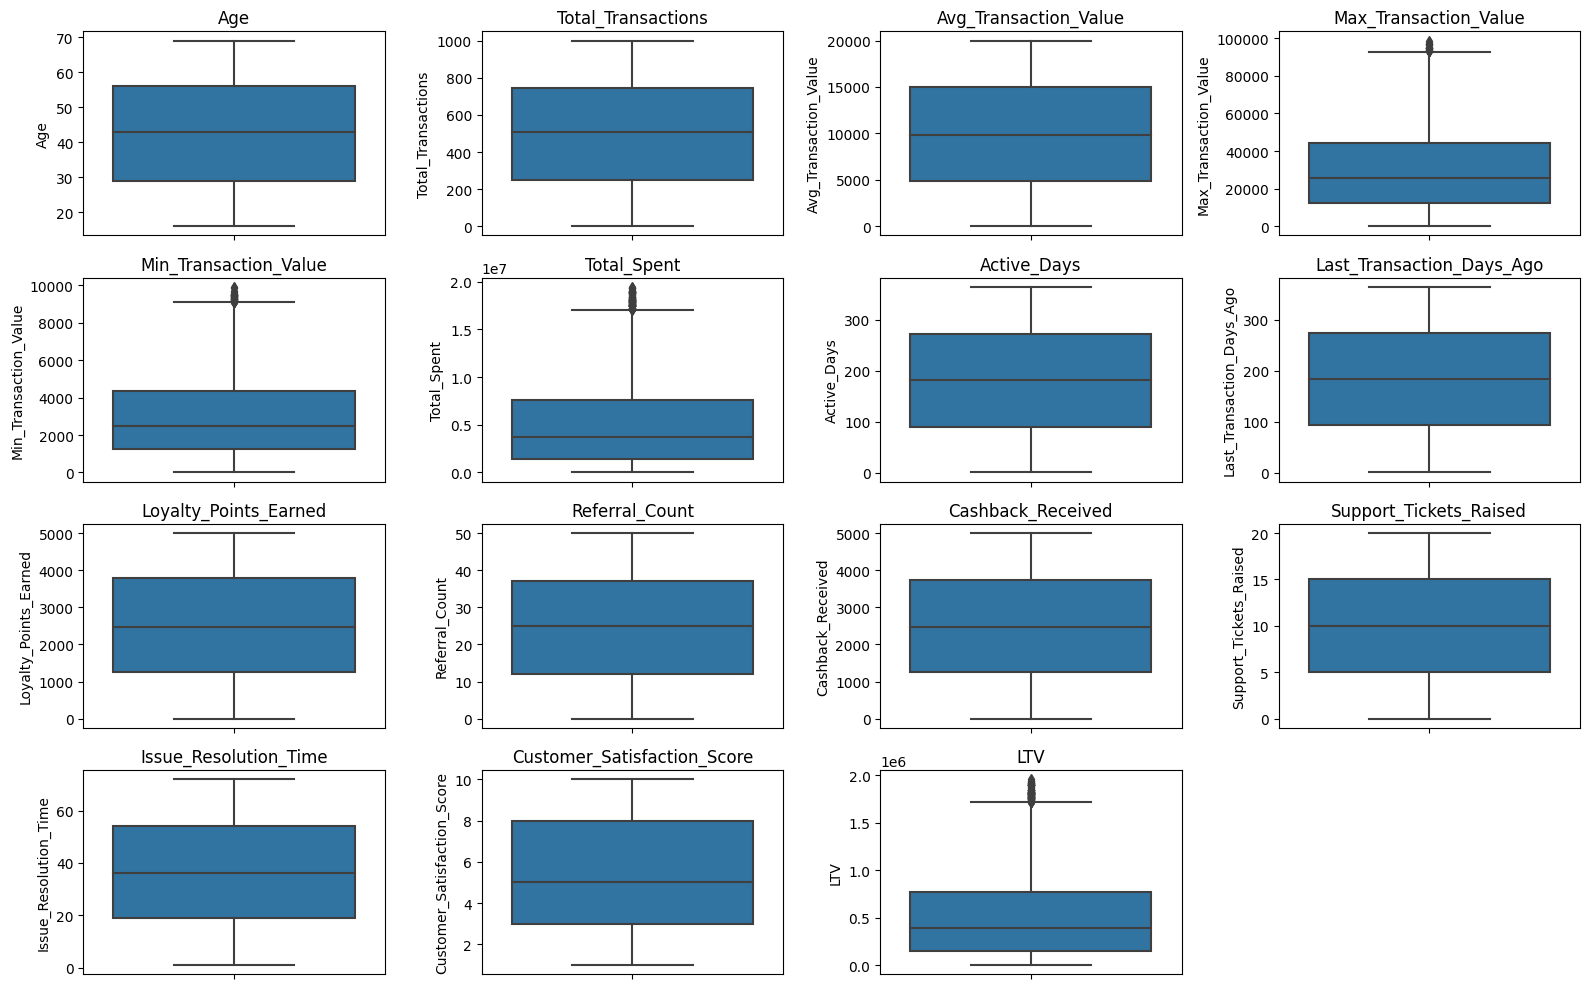

In [135]:
# Numeric feature boxplots (outlier detection)
numeric_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

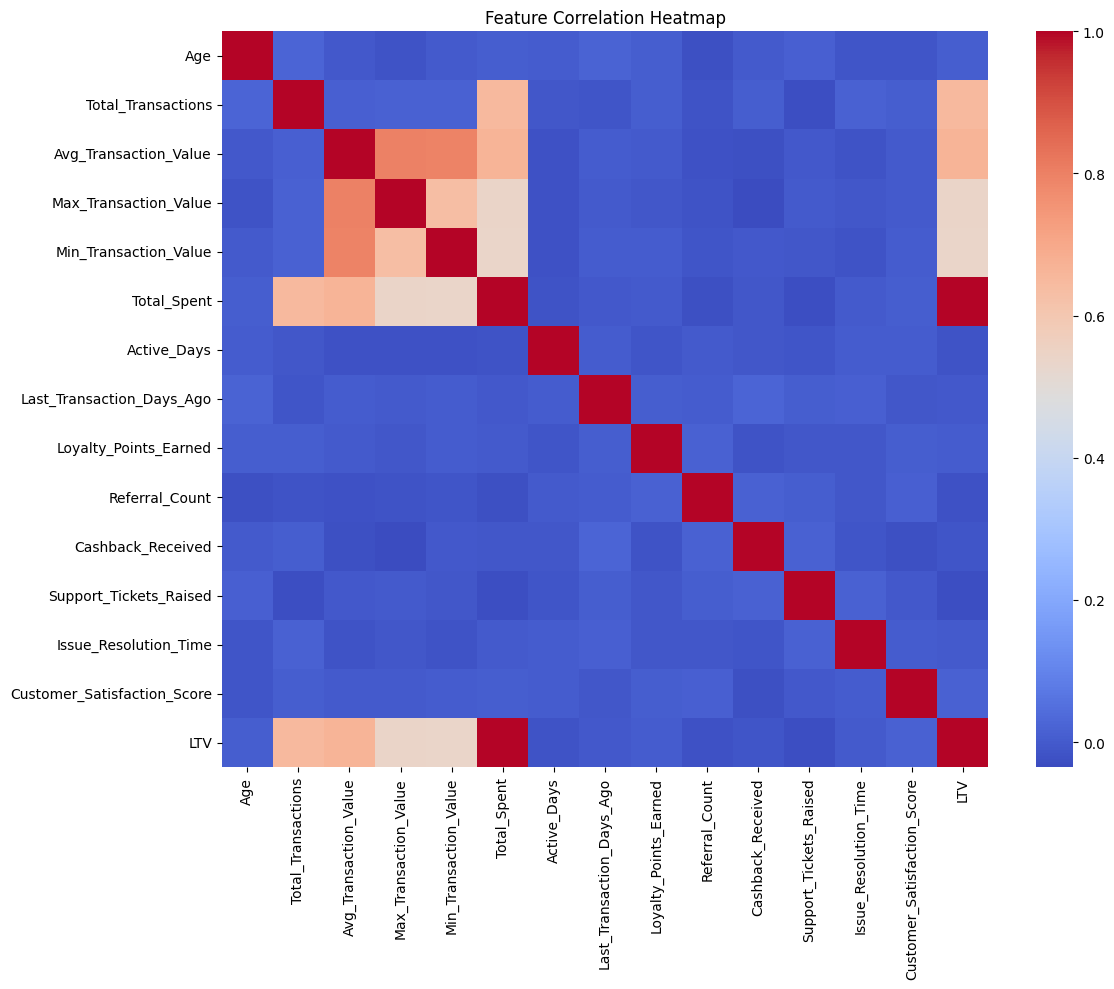

In [136]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [137]:
# Transaction Frequency
df['Transaction_Frequency'] = df['Total_Transactions'] / df['Active_Days']
df['Transaction_Frequency'].describe()

count    7000.000000
mean        9.027255
std        37.715227
min         0.002793
25%         1.405718
50%         2.755357
75%         5.548746
max       979.000000
Name: Transaction_Frequency, dtype: float64

## 5. Data Preprocessing (Encoding, Scaling)

In [138]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
df_encoded = df.copy()
# Encode categorical variables
for col in ['Location', 'Income_Level', 'App_Usage_Frequency', 'Preferred_Payment_Method']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
# Drop Customer_ID
df_encoded = df_encoded.drop('Customer_ID', axis=1)
# Scale features
scaler = StandardScaler()
X = df_encoded.drop(['LTV', 'Total_Spent'], axis=1)
y = df_encoded['LTV']
X_scaled = scaler.fit_transform(X)

## 6. Model Implementation and Comparison (5+ Algorithms)

### 6.1  Setup & Data Splitting

In [139]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import pandas as pd
import numpy as np
import logging


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
results = {}

### 6.2  Linear Regression

In [152]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results['Linear Regression'] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}


### 6.3  Ridge Regression

In [153]:
param_grid = {'alpha': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_ridge = grid.best_estimator_
print("Best Ridge Regression params:", grid.best_params_)

y_pred = best_ridge.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results['Ridge Regression'] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}


Best Ridge Regression params: {'alpha': 0.1}


### 6.4  Lasso Regression

In [142]:
param_grid = {'alpha': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_lasso = grid.best_estimator_
print("Best Lasso Regression params:", grid.best_params_)

y_pred = best_lasso.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results['Lasso Regression'] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

Best Lasso Regression params: {'alpha': 10}


### 6.5 Random Forest Regressor

In [143]:
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best Random Forest params:", grid.best_params_)

y_pred = best_rf.predict(X_test)
results['Random Forest'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}


Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


### 6.6 Gradient Boosting Regressor

In [144]:
gb_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_gb = grid.best_estimator_
print("Best Gradient Boosting params:", grid.best_params_)

y_pred = best_gb.predict(X_test)
results['Gradient Boosting'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


### 6.7 Support Vector Regressor (SVR)

In [154]:
svr_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVR(), svr_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_svr = grid.best_estimator_
print("Best SVR params:", grid.best_params_)

y_pred = best_svr.predict(X_test)
results['SVR'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}


Best SVR params: {'C': 10, 'epsilon': 1, 'kernel': 'linear'}


### 6.8 LightGBM Regressor

In [147]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

X_train_df = pd.DataFrame(X_train)
low_var_cols = X_train_df.columns[X_train_df.nunique() <= 1]
if len(low_var_cols) > 0:
    print("Dropping constant features:", list(low_var_cols))
    X_train_df = X_train_df.drop(columns=low_var_cols)
    X_test_df = pd.DataFrame(X_test).drop(columns=low_var_cols)
    X_train = X_train_df.values
    X_test = X_test_df.values
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

best_lgbm = LGBMRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=-1,
    min_child_samples=1,
    min_split_gain=0.0,
    force_row_wise=True,
    random_state=42,
    verbose=-1
)
best_lgbm.fit(X_train, y_train_scaled)
best_lgbm_params = {
    'learning_rate': best_lgbm.learning_rate,
    'n_estimators': best_lgbm.n_estimators,
    'max_depth': best_lgbm.max_depth,
    'min_child_samples': best_lgbm.min_child_samples,
    'min_split_gain': best_lgbm.min_split_gain
}
print(f"Best LightGBM params: {best_lgbm_params}")

y_pred_scaled = best_lgbm.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

results['LightGBM'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

Best LightGBM params: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': -1, 'min_child_samples': 1, 'min_split_gain': 0.0}


### 6.9 CatBoost Regressor

In [148]:
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 10]
}

catboost_grid = GridSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    catboost_param_grid, cv=3,
    scoring='neg_mean_squared_error', n_jobs=-1
)
catboost_grid.fit(X_train, y_train)

best_catboost = catboost_grid.best_estimator_
print("Best CatBoost params:", catboost_grid.best_params_)

y_pred = best_catboost.predict(X_test)
results['CatBoost'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

Best CatBoost params: {'depth': 5, 'iterations': 300, 'learning_rate': 0.1}


### 6.10 XGBoost Regressor

In [149]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10]
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42),
    xgb_param_grid, cv=3,
    scoring='neg_mean_squared_error', n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("Best XGBoost params:", xgb_grid.best_params_)

y_pred = best_xgb.predict(X_test)
results['XGBoost'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}


Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300}


### 6.11 Stacking Regressor

In [155]:
# Reuse the best models from previous blocks: best_ridge, best_lasso, best_rf, best_gb, best_lgbm, best_catboost, best_xgb
stacking_estimators = [
    ('ridge', best_ridge),
    ('lasso', best_lasso),
    ('random_forest', best_rf),
    ('gradient_boosting', best_gb),
    ('lightgbm', best_lgbm),
    ('catboost', best_catboost),
    ('xgboost', best_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_estimators,
    final_estimator=LinearRegression()
)
stacking_regressor.fit(X_train, y_train)

y_pred = stacking_regressor.predict(X_test)
results['Stacking'] = {
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

### 6.12 Results

In [156]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')
results_df

,RMSE,MAE,R2
Stacking,6266.673774,4573.514932,0.999798
XGBoost,8267.145994,6015.019664,0.999649
Random Forest,8623.019684,6267.140459,0.999618
LightGBM,9612.212467,7147.939405,0.999525
Gradient Boosting,10134.828877,7506.965482,0.999472
CatBoost,10683.449960,8070.826610,0.999414
Lasso Regression,169178.691901,126232.610518,0.853002
Linear Regression,169181.899054,126236.789226,0.852997
Ridge Regression,169181.942381,126236.882935,0.852997
SVR,390884.404790,290330.708942,0.215279


## 7. Feature Importance (for Tree-Based Models)

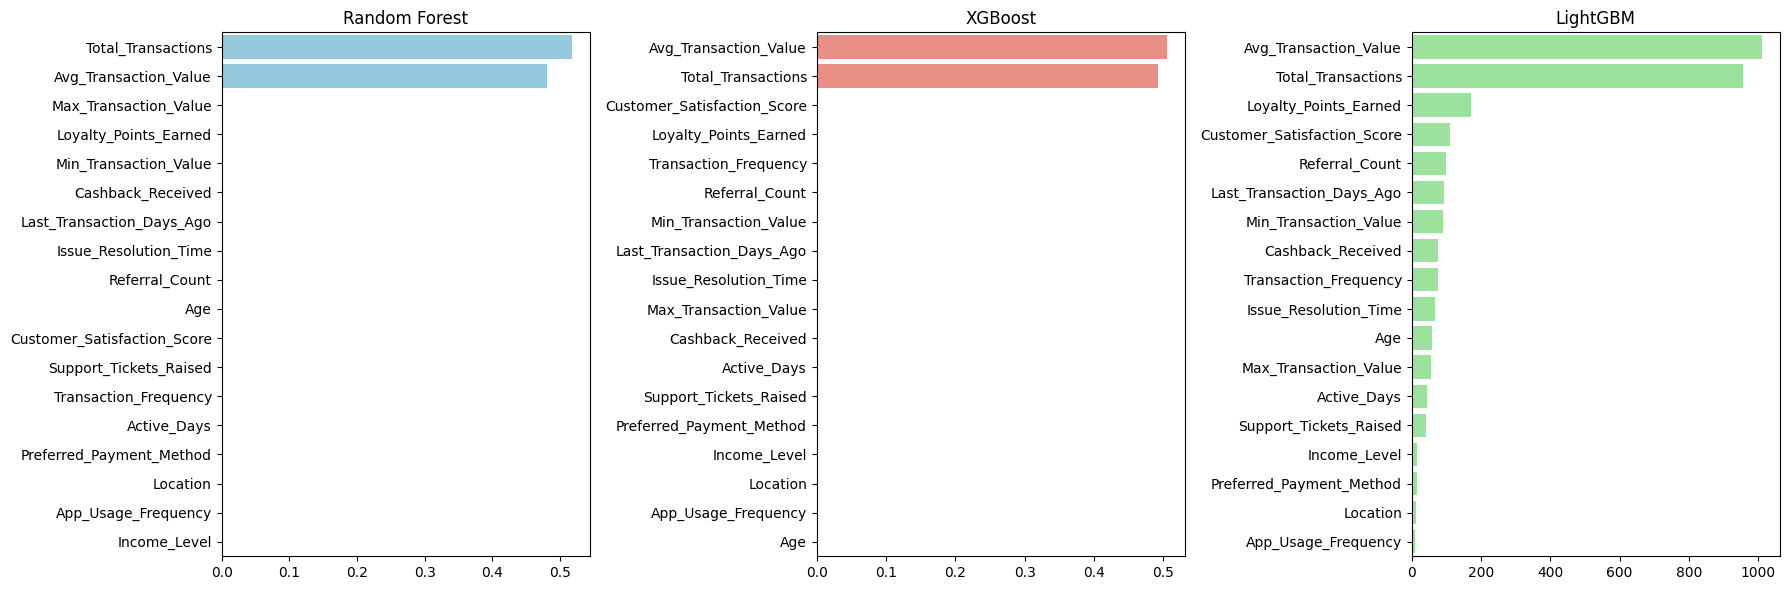

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Fit models (assuming X_train, y_train already exist)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# Create feature importance series
rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
lgbm_imp = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=rf_imp.values, y=rf_imp.index, ax=axes[0], color='skyblue')
axes[0].set_title("Random Forest")

sns.barplot(x=xgb_imp.values, y=xgb_imp.index, ax=axes[1], color='salmon')
axes[1].set_title("XGBoost")

sns.barplot(x=lgbm_imp.values, y=lgbm_imp.index, ax=axes[2], color='lightgreen')
axes[2].set_title("LightGBM")

plt.tight_layout()
plt.show()


## 8. Business Insights and Recommendations

* In the initial model runs, **`Total_Spent` emerged as a dominant predictor of LTV**, resulting in near-perfect R² scores for most models (except SVR). This highlighted an overfitting risk driven by a single feature — a common trait in synthetic datasets, but rarely reflective of real-world behavior.
* After removing `Total_Spent`, performance became more realistic:
  * **Tree-based models** (Random Forest, Gradient Boosting, LightGBM, XGBoost) maintained strong accuracy due to their ability to capture non-linear interactions.
  * **Linear models** (Linear, Ridge, Lasso) dropped in performance, showing their limitations in modeling complex relationships.
  * **SVR**, after tuning, significantly improved — showcasing its strength in high-dimensional, balanced feature spaces.
* **Feature importance analysis** post-`Total_Spent` removal revealed `Total_Transactions` and `Avg_Transaction_Value` as consistent top predictors, making them valuable business levers.
* For a company like **Revolut**, these insights can directly inform customer segmentation, targeted offers, and LTV-based personalization strategies.
* **Caution:** Always assess for **feature dominance** in training data, especially in synthetic or bootstrapped datasets. For production, ensure models are validated against **real-world customer behavior**.


## 9. Justification of Dataset Choice

* The dataset used is **synthetic**, but was designed to closely mirror real-world **digital wallet usage patterns**, incorporating a mix of demographic, behavioral, and transactional features.
* It satisfies project criteria:
  * ✅ **Sufficient size** (7000 entries)
  * ✅ **Diverse features** (20+ across multiple domains)
  * ✅ **No missing values or duplicates**
* This makes it highly suitable for benchmarking and experimentation with **LTV prediction models**.
* For deployment in a real-world fintech setting (e.g., Revolut), we recommend retraining the model using **live transactional and user profile data**.


### 10. Business Insights

* **Primary Drivers of LTV:**
  * High-frequency, high-value transactions are key to customer lifetime value.
  * Features tied to **user engagement** (referrals, loyalty points, cashback) also play a measurable role.

* **Recommended Strategies:**
  * Launch targeted **campaigns to boost transaction frequency and value**, especially for mid-tier users showing high potential.
  * **Enhance loyalty programs** to incentivize repeat usage and long-term retention.
  * **Monitor user friction points** such as `Issue_Resolution_Time` and `Support_Tickets_Raised` — high friction may erode long-term value despite strong early usage.
  * Invest in **real-time LTV monitoring** powered by the deployed ensemble model for more personalized, data-driven marketing and risk mitigation.

* **Model Deployment:**
  * Deploy the **Stacking Regressor** as the primary prediction engine.
  * Establish a **model retraining pipeline** using live customer data to adapt to evolving behavioral patterns and transaction trends.
